# Initial google trends 

In [ ]:
from time import sleep
import csv

import pandas as pd
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as pyplot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#we look through the docs for read_csv and find the "skip row" parameter
googletrends = pd.read_csv('/content/drive/MyDrive/time_series/googletrends_chipotle2013.csv', skiprows = [0,1], parse_dates=['Week'])

In [ ]:
googletrends.index = googletrends['Week']
del googletrends['Week']

In [ ]:
#1. always to set the index as the date column
googletrends.tail()

,chipotle: (United States)
Week,
2018-09-16,45
2018-09-23,48
2018-09-30,50
2018-10-07,48
2018-10-14,47


In [ ]:
#let's get a sense of what the variation in the data is.
#standard deviation is 5.83. Varies from 70 to 100.
print(googletrends['chipotle: (United States)'].describe())

count    263.000000
mean      50.771863
std        8.286914
min       34.000000
25%       45.000000
50%       50.000000
75%       54.000000
max      100.000000
Name: chipotle: (United States), dtype: float64


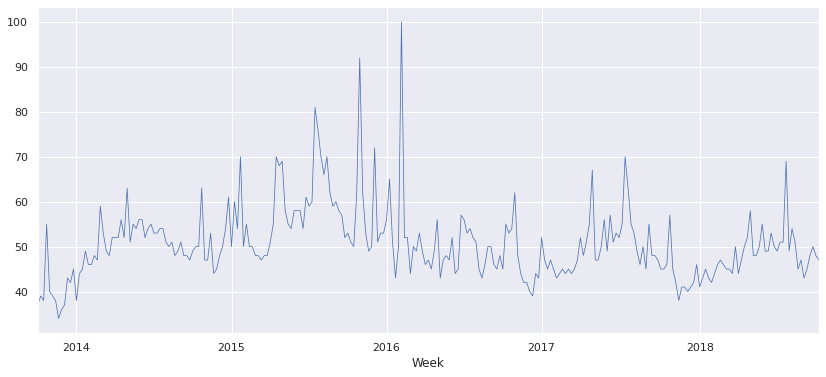

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 6)})
googletrends['chipotle: (United States)'].plot(linewidth=0.75)

# Learning more about the time series (ADF/ACF/PACF)

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
adf_test(googletrends['chipotle: (United States)'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.596005
p-value                          0.093826
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [ ]:
googletrends['trends_diff_1'] = googletrends['chipotle: (United States)'].diff(1)

In [ ]:
googletrends

,chipotle: (United States),trends_diff_1
Week,,
2013-10-06,37,NaN
2013-10-13,39,2.0
2013-10-20,38,-1.0
2013-10-27,55,17.0
2013-11-03,40,-15.0
...,...,...
2018-09-16,45,2.0
2018-09-23,48,3.0
2018-09-30,50,2.0


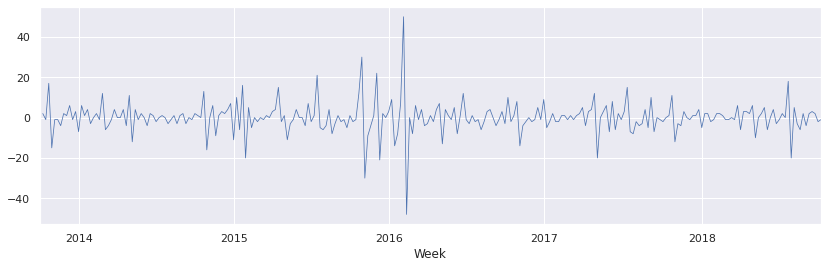

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
googletrends['trends_diff_1'].plot(linewidth=0.75)

In [ ]:
adf_test(googletrends['trends_diff_1'][1:])
# now pvalue is significant so we can reject the null and say that the data has stationarity 
#The null hypothesis for both tests is that the data are non-stationary#

Results of Dickey-Fuller Test:
Test Statistic                  -3.778675
p-value                          0.003133
#Lags Used                      16.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


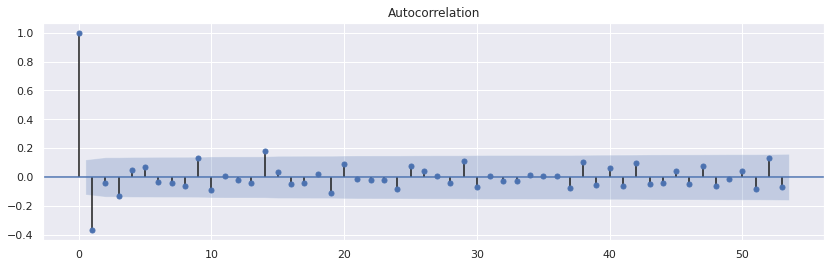

In [ ]:
plot_acf(googletrends['trends_diff_1'][1:], lags=53);

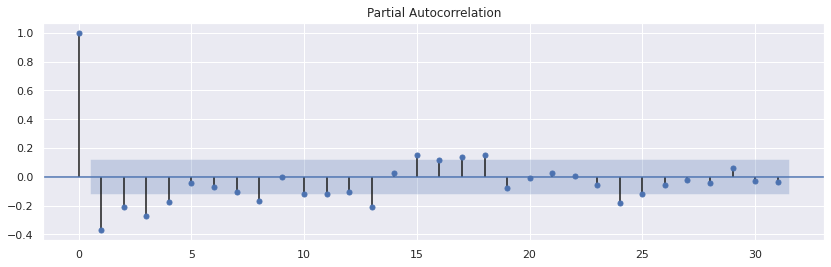

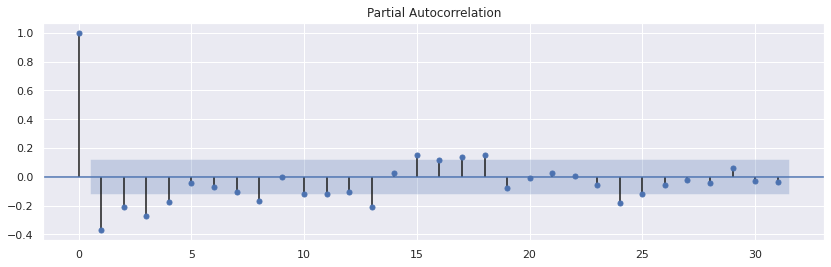

In [ ]:
plot_pacf(googletrends['trends_diff_1'][1:], lags=31)
# plotting the residuals to see if the errors have a correlation with itself that we are left with (unexplained variance)

# SARIMAX MODEL

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
adspend = pd.read_csv('/content/drive/MyDrive/time_series/chipotle.adspend.csv')

In [ ]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Chipotle Mexican Grill : General Promotion - QSR,54.8,0.0,0.0,0.0,0.0,0.0,0.0,54.8,0.0
1,"WEEK OF OCT 14, 2013 (B)",Chipotle Mexican Grill : General Promotion - QSR,54.8,0.0,0.0,0.0,0.0,0.0,0.0,54.8,0.0
2,"WEEK OF OCT 21, 2013 (B)",Chipotle Mexican Grill : General Promotion - QSR,54.8,0.0,0.0,0.0,0.0,0.0,0.0,54.8,0.0
3,"WEEK OF OCT 28, 2013 (B)",Chipotle Mexican Grill : General Promotion - QSR,183.5,0.0,0.0,0.0,0.0,0.0,0.0,31.3,152.2
4,"WEEK OF NOV 25, 2013 (B)",Chipotle Mexican Grill : General Promotion - QSR,165.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.4


In [ ]:
adspend.columns

Index(['TIME PERIOD', 'PRODUCT', 'TOTAL DOLS (000)', 'NETWORK TV DOLS (000)',
       'CABLE TV DOLS (000)', 'SPOT TV DOLS (000)', 'MAGAZINES DOLS (000)',
       'NATL NEWSP DOLS (000)', 'NEWSPAPER DOLS (000)',
       'NAT SPOT RADIO DOLS (000)', 'OUTDOOR DOLS (000)'],
      dtype='object')

In [ ]:
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF ", "")
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "") #\escape character
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "") #\escape character
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])
adspendnoproducts=adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

In [ ]:
adspendnoproducts.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-25', '2013-12-16', '2013-12-30', '2014-01-27',
               '2014-02-03', '2014-02-10',
               ...
               '2018-07-30', '2018-08-06', '2018-08-13', '2018-08-20',
               '2018-08-27', '2018-09-03', '2018-09-10', '2018-09-17',
               '2018-09-24', '2018-10-01'],
              dtype='datetime64[ns]', name='FIXED TIME', length=181, freq=None)

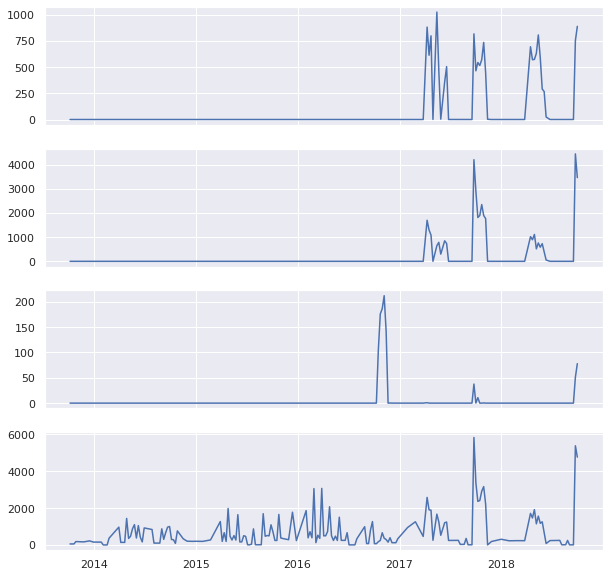

In [ ]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NETWORK TV'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV']) #Spot cable is one of two basic ways to buy advertising on cable television. It allows regional small-business owners to show their TV ads on national cable networks that air in their local markets without having to buy airtime from those networks.
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

In [ ]:
testdate = pd.to_datetime("2013-10-07")
testdate.weekday() # this is monday

0

In [ ]:
googletrends.head()

,chipotle: (United States),trends_diff_1
Week,,
2013-10-06,37,NaN
2013-10-13,39,2.0
2013-10-20,38,-1.0
2013-10-27,55,17.0
2013-11-03,40,-15.0


In [ ]:
adspendnoproducts['FIXED DATE'] = adspendnoproducts.index - pd.DateOffset(1)

In [ ]:
adspendnoproducts['FIXED DATE']

FIXED TIME
2013-10-07   2013-10-06
2013-10-14   2013-10-13
2013-10-21   2013-10-20
2013-10-28   2013-10-27
2013-11-25   2013-11-24
                ...    
2018-09-03   2018-09-02
2018-09-10   2018-09-09
2018-09-17   2018-09-16
2018-09-24   2018-09-23
2018-10-01   2018-09-30
Name: FIXED DATE, Length: 181, dtype: datetime64[ns]

In [ ]:
adspendnoproducts.index = adspendnoproducts['FIXED DATE']
del adspendnoproducts['FIXED DATE']

In [ ]:
adspendnoproducts

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,TOTAL
FIXED DATE,,,,,,,,,
2013-10-06,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8
2013-10-13,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8
2013-10-20,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8
2013-10-27,0.0,0.0,31.3,0.0,0.0,0.0,152.2,0.0,183.5
2013-11-24,0.0,0.0,0.0,0.0,0.0,0.0,165.4,0.0,165.4
...,...,...,...,...,...,...,...,...,...
2018-09-02,0.0,0.0,5.9,0.0,0.0,0.0,0.0,0.0,5.9
2018-09-09,0.0,0.0,5.9,0.0,0.0,0.0,0.0,0.0,5.9
2018-09-16,0.0,0.0,5.9,0.0,0.0,0.0,0.0,0.0,5.9


In [ ]:
googletrends['TOTAL ADSPEND'] = adspendnoproducts['TOTAL']
googletrends['NAT SPOT RADIO'] = adspendnoproducts['NAT SPOT RADIO']
googletrends['CABLE TV'] = adspendnoproducts['CABLE TV']


In [ ]:
googletrends

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV
Week,,,,,
2013-10-06,37,NaN,54.8,54.8,0.0
2013-10-13,39,2.0,54.8,54.8,0.0
2013-10-20,38,-1.0,54.8,54.8,0.0
2013-10-27,55,17.0,183.5,31.3,0.0
2013-11-03,40,-15.0,NaN,NaN,NaN
...,...,...,...,...,...
2018-09-16,45,2.0,5.9,5.9,0.0
2018-09-23,48,3.0,5381.4,5.9,752.4
2018-09-30,50,2.0,4766.2,13.1,888.0


In [ ]:
googletrends_droplastrow = googletrends[:-1]

In [ ]:
# replace NaN with means 
googletrends_droplastrow['TOTAL ADSPEND'].fillna(value=googletrends_droplastrow['TOTAL ADSPEND'].mean(),inplace=True)
googletrends_droplastrow['NAT SPOT RADIO'].fillna(value=googletrends_droplastrow['NAT SPOT RADIO'].mean(),inplace=True)
googletrends_droplastrow['CABLE TV'].fillna(value=googletrends_droplastrow['CABLE TV'].mean(),inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
googletrends_droplastrow.columns
googletrends_droplastrow.shape

(262, 5)

In [ ]:
df_train = googletrends_droplastrow.iloc[:222,:]
df_test = googletrends_droplastrow.iloc[222:,:]
print("Shape of new dataframes - {} , {}".format(df_test.shape, df_train.shape))

Shape of new dataframes - (40, 5) , (222, 5)


In [ ]:
df_train

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV
Week,,,,,
2013-10-06,37,NaN,54.800000,54.800000,0.000000
2013-10-13,39,2.0,54.800000,54.800000,0.000000
2013-10-20,38,-1.0,54.800000,54.800000,0.000000
2013-10-27,55,17.0,183.500000,31.300000,0.000000
2013-11-03,40,-15.0,688.545304,92.243646,81.921547
...,...,...,...,...,...
2017-12-03,41,0.0,688.545304,92.243646,81.921547
2017-12-10,40,-1.0,688.545304,92.243646,81.921547
2017-12-17,41,1.0,688.545304,92.243646,81.921547


In [ ]:
df_test

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV
Week,,,,,
2018-01-07,41,-5.0,688.545304,92.243646,81.921547
2018-01-14,43,2.0,688.545304,92.243646,81.921547
2018-01-21,45,2.0,688.545304,92.243646,81.921547
2018-01-28,43,-2.0,226.500000,0.000000,0.000000
2018-02-04,42,-1.0,688.545304,92.243646,81.921547
2018-02-11,44,2.0,688.545304,92.243646,81.921547
2018-02-18,46,2.0,688.545304,92.243646,81.921547
2018-02-25,47,1.0,233.400000,0.000000,0.000000
2018-03-04,46,-1.0,688.545304,92.243646,81.921547


In [ ]:
model = sm.tsa.statespace.SARIMAX(df_train['chipotle: (United States)'], trend='t', order=(1,1,0), 
                                  exog = df_train['TOTAL ADSPEND'])
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               Statespace Model Results                              
Dep. Variable:     chipotle: (United States)   No. Observations:                  222
Model:                      SARIMAX(1, 1, 0)   Log Likelihood                -765.081
Date:                       Tue, 04 May 2021   AIC                           1538.162
Time:                               01:25:20   BIC                           1551.755
Sample:                           10-06-2013   HQIC                          1543.651
                                - 12-31-2017                                         
Covariance Type:                         opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
drift            -0.0005      0.005     -0.107      0.915      -0.010       0.009
TOTAL ADSPEND    -0.0008      0.001     -0.852      0.394      -0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


sarimax model with stocks data and adspend

In [ ]:
stock = pd.read_csv('/content/drive/MyDrive/time_series/CMG.csv')

In [ ]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-07,430.000000,443.929993,423.250000,443.609985,443.609985,2322500
1,2013-10-14,441.420013,511.100006,432.929993,509.739990,509.739990,4945300
2,2013-10-21,509.589996,528.000000,506.500000,527.500000,527.500000,3213000
3,2013-10-28,527.000000,531.429993,521.440002,527.599976,527.599976,1731900
4,2013-11-04,529.500000,546.799988,524.669983,535.200012,535.200012,2325000


In [ ]:
df = stock.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-07,430.000000,443.929993,423.250000,443.609985,443.609985,2322500
2013-10-14,441.420013,511.100006,432.929993,509.739990,509.739990,4945300
2013-10-21,509.589996,528.000000,506.500000,527.500000,527.500000,3213000
2013-10-28,527.000000,531.429993,521.440002,527.599976,527.599976,1731900
2013-11-04,529.500000,546.799988,524.669983,535.200012,535.200012,2325000


In [ ]:
stock_pt = df.pivot_table(index='Date', aggfunc=np.sum)

In [ ]:
stock_pt.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-04', '2013-11-11', '2013-11-18', '2013-11-25',
               '2013-12-02', '2013-12-09',
               ...
               '2018-07-23', '2018-07-30', '2018-08-06', '2018-08-13',
               '2018-08-20', '2018-08-27', '2018-09-03', '2018-09-10',
               '2018-09-17', '2018-09-24'],
              dtype='datetime64[ns]', name='Date', length=260, freq=None)

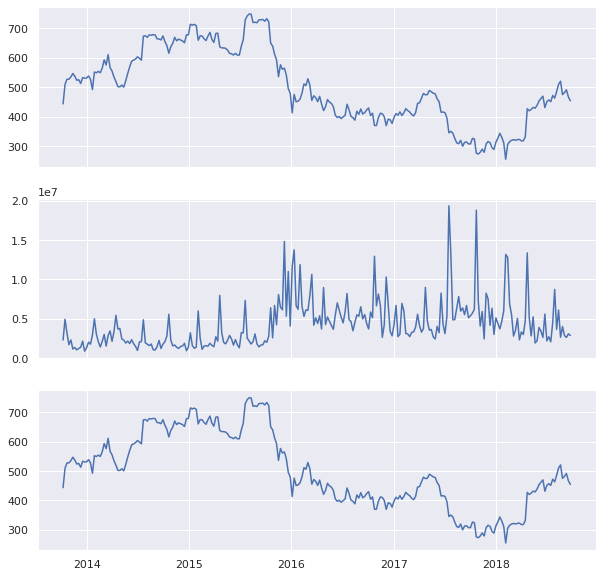

In [ ]:
dimensions = (10, 10)
fig, (ax1, ax2,ax3) = pyplot.subplots(3, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(stock_pt.index, df['Adj Close'])
ax2.plot(stock_pt.index, df['Volume'])
ax3.plot(stock_pt.index, df['Close'])


In [ ]:
testdate = pd.to_datetime("2013-10-07")
testdate.weekday() # this is monday

0

In [ ]:
googletrends.head()

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV
Week,,,,,
2013-10-06,37,NaN,54.800000,54.800000,0.000000
2013-10-13,39,2.0,54.800000,54.800000,0.000000
2013-10-20,38,-1.0,54.800000,54.800000,0.000000
2013-10-27,55,17.0,183.500000,31.300000,0.000000
2013-11-03,40,-15.0,688.545304,92.243646,81.921547


In [ ]:
df['Date'] = df.index - pd.DateOffset(1)

In [ ]:
df['Date']

Date
2013-10-07   2013-10-06
2013-10-14   2013-10-13
2013-10-21   2013-10-20
2013-10-28   2013-10-27
2013-11-04   2013-11-03
                ...    
2018-08-27   2018-08-26
2018-09-03   2018-09-02
2018-09-10   2018-09-09
2018-09-17   2018-09-16
2018-09-24   2018-09-23
Name: Date, Length: 260, dtype: datetime64[ns]

In [ ]:
df.index = df['Date']
del df['Date']

In [ ]:
googletrends['Stock Adj Close'] = df['Adj Close']

In [ ]:
googletrends

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV,Stock Adj Close
Week,,,,,,
2013-10-06,37,NaN,54.800000,54.800000,0.000000,443.609985
2013-10-13,39,2.0,54.800000,54.800000,0.000000,509.739990
2013-10-20,38,-1.0,54.800000,54.800000,0.000000,527.500000
2013-10-27,55,17.0,183.500000,31.300000,0.000000,527.599976
2013-11-03,40,-15.0,688.545304,92.243646,81.921547,535.200012
...,...,...,...,...,...,...
2018-09-16,45,2.0,5.900000,5.900000,0.000000,467.369995
2018-09-23,48,3.0,5381.400000,5.900000,752.400000,454.519989
2018-09-30,50,2.0,4766.200000,13.100000,888.000000,NaN


In [ ]:
googletrends_droplastrow = googletrends[:-1]

In [ ]:
# filling nulls with mean for adj close
googletrends_droplastrow['Stock Adj Close'].fillna(value=googletrends_droplastrow['Stock Adj Close'].mean(),inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
googletrends_droplastrow

,chipotle: (United States),trends_diff_1,TOTAL ADSPEND,NAT SPOT RADIO,CABLE TV,Stock Adj Close
Week,,,,,,
2013-10-06,37,NaN,54.800000,54.800000,0.000000,443.609985
2013-10-13,39,2.0,54.800000,54.800000,0.000000,509.739990
2013-10-20,38,-1.0,54.800000,54.800000,0.000000,527.500000
2013-10-27,55,17.0,183.500000,31.300000,0.000000,527.599976
2013-11-03,40,-15.0,688.545304,92.243646,81.921547,535.200012
...,...,...,...,...,...,...
2018-09-09,43,-4.0,5.900000,5.900000,0.000000,491.559998
2018-09-16,45,2.0,5.900000,5.900000,0.000000,467.369995
2018-09-23,48,3.0,5381.400000,5.900000,752.400000,454.519989


In [ ]:
model = sm.tsa.statespace.SARIMAX(googletrends_droplastrow['chipotle: (United States)'], trend='t', order=(1,1,0), 
                                  exog = googletrends_droplastrow[['TOTAL ADSPEND','Stock Adj Close','NAT SPOT RADIO','CABLE TV']])
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                               Statespace Model Results                              
Dep. Variable:     chipotle: (United States)   No. Observations:                  262
Model:                      SARIMAX(1, 1, 0)   Log Likelihood                -888.509
Date:                       Tue, 04 May 2021   AIC                           1791.019
Time:                               01:31:07   BIC                           1815.970
Sample:                           10-06-2013   HQIC                          1801.049
                                - 10-07-2018                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
drift              -0.0001      0.004     -0.031      0.975      -0.008       0.007
TOTAL ADSPEND   -6.096e-06      0.001     -0.007      0.994 

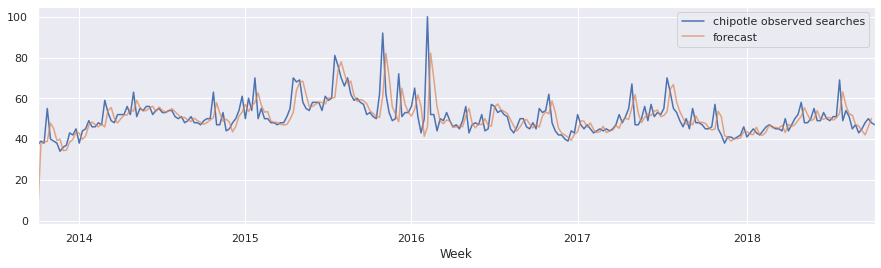

<Figure size 1008x288 with 0 Axes>

In [90]:
pred = model_fit.get_prediction()
pred_ci = model_fit.conf_int()
ax = googletrends['chipotle: (United States)'].plot(label='chipotle observed searches')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(15, 4))
plt.legend()
plt.show()



In [ ]:
import math
import statistics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_preds = pred.predicted_mean
y_true = googletrends['chipotle: (United States)']

# error metrics
rmse = math.sqrt(((y_preds - y_true) ** 2).mean())
mae = statistics.mean(abs(y_true - y_preds))

print((round(rmse, 2)))
print((round(mape(y_true, y_preds),2)))

7.56
8.62


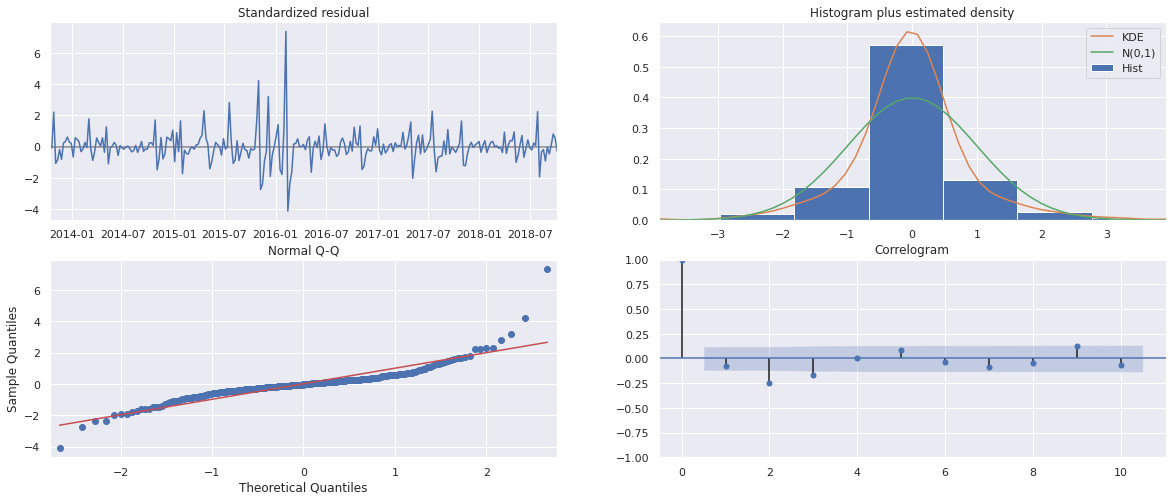

In [ ]:
model_fit.plot_diagnostics(figsize=(20, 8))
plt.show()